## Part II.머신러닝 실무 프로젝트

#### Chapter 9 - PJT 3 : Uplift modeling - 마케팅 효율개선 

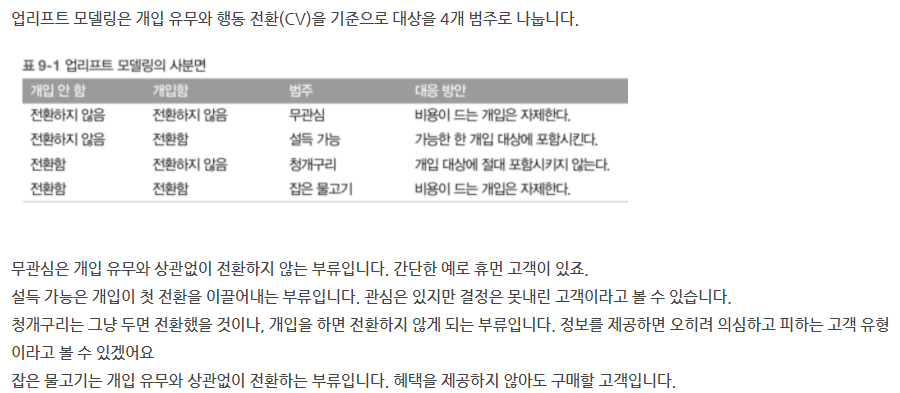

In [1]:
### Theory of Uplift model
from IPython.display import Image
Image("img/aaaa.png")

### Practice 
- data : The mine that e-mail analytics and data mining challenge 
- source url : http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
- description : 12개월간 구매이력 고객대상, 무작위 메일 발송 (남성타겟 / 여성타겟 / 미발송) 후 구매연결 여부 조사 
- fields (12) : 
  - recency : 최종 구매후 경과시간 
  - history : 최근 1년간 구매금액 
  - history_segment : 최근 1년간 구매금액에 따른 카테고리 분류 
  - mens, womens : 최근 1년간 남성용/여성용 제굼 구매여부 
  - zip_code : 우편번호 (urban / suburban / rural) 
  - newbie : 최근 1년 신규가입 고객 여부 
  - channel : 최근 1년 구매경로 
  - segment : 고객에게 발송한 판촉메일 유형 
  - visit / conversion / spend : 판촉메일 수신 후 2주내, 사이트 방문여부 / 구매여부 / 구매금액   

In [2]:
### data loading 
import urllib.request 
cvs_url = "http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv" 
cvs_filename = 'source_data.csv'

with open(cvs_filename, 'w') as fp : 
    data = urllib.request.urlopen(cvs_url).read()
    fp.write(data.decode('ascii'))

In [3]:
import pandas as pd 
source_df = pd.read_csv(cvs_filename)

print(source_df.shape)
source_df.head()

(64000, 12)


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


#### <font color = 'yellow'> 1. 데이터 전처리 </font>
- 메일 미발송 고객 삭제 
- cetegory 변수 dummy 변환 (zip_code, channel
- 남성용 메일발송, 사이트 방문에 대해 flag를 달아 준다. 
- training / test dataset 분리

In [4]:
### 타겟메일이 발송되지 않은 고객은 삭제 

mailed_df = source_df[source_df['segment'] != 'No E-Mail']
mailed_df = mailed_df.reset_index(drop = True)     ### 인덱스를 다시 지정 
mailed_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
2,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
3,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
4,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0


In [5]:
### zip_code와 channel 컬럼을 더미변수로 변환 

dummied_df = pd.get_dummies(mailed_df[["zip_code", "channel"]], drop_first=True)

feature_vector_df = mailed_df.drop(["history_segment", "zip_code", "channel", "segment", "visit", "conversion", "spend"], axis=1)
feature_vector_df = feature_vector_df.join(dummied_df)
feature_vector_df.head()

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0
1,7,180.65,0,1,1,1,0,0,1
2,9,675.83,1,0,1,0,0,0,1
3,2,45.34,1,0,0,0,1,0,1
4,6,134.83,0,1,0,1,0,1,0


In [6]:
### 남성용 메일을 보낸 경우를 실험군으로 삼기 위해 플래그를 붙인다. 
### 사이트를 방문한 경우도 플래깅. 

is_treat_list = list(mailed_df["segment"] == "Mens E-Mail")
is_cv_list = list(mailed_df["visit"] == 1)

print(is_treat_list[:5])
print(is_cv_list[:5])

[False, False, True, False, False]
[False, False, False, False, True]


In [7]:
### dataset 분리 
from sklearn.model_selection import train_test_split

train_is_cv_list, test_is_cv_list, train_is_treat_list, test_is_treat_list, train_feature_vector_df, test_feature_vector_df = train_test_split(is_cv_list, is_treat_list, feature_vector_df, test_size=0.5,  random_state=42)

#### <font color = 'yellow'> 2. Modeling </font>

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
from sklearn.linear_model import LogisticRegression

treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

train_sample_num = len(train_is_cv_list)

treat_is_cv_list = [train_is_cv_list[i] for i in range(train_sample_num) if train_is_treat_list[i] == True]

treat_feature_vector_list = train_feature_vector_df[train_is_treat_list]

control_is_cv_list = [train_is_cv_list[i] for i in range(train_sample_num) if train_is_treat_list[i] == False]

control_feature_vector_list = train_feature_vector_df[list(map(lambda a:a == False ,train_is_treat_list))]

treat_model.fit(treat_feature_vector_list, treat_is_cv_list)

control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01)

In [23]:
from operator import itemgetter

treat_score = treat_model.predict_proba(test_feature_vector_df)
control_score = control_model.predict_proba(test_feature_vector_df)
score_list = treat_score[:,1] / control_score[:,1]

result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2),reverse=True)

treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu

# 두 그룹의 전환율 차이에서 실험군의 사람 수를 곱하는 방법으로 lift를 계산한다
# 비율(CVR)의 차이이므로 실험군과 대조군의 크기가 달라도 무방하다.
lift = (treat_cvr - control_cvr) * treat_uu
stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

print(stat_data[:10])

[[False, False, 0.8411304467771199, 10583, 10764, 1961, 1698, 0.18529717471416424, 0.15774804905239687, 291.5523968784841]]


In [24]:
import matplotlib.font_manager 
plt.rcParams["font.family"] = "Gulim"

Text(0, 0.5, '전환율')

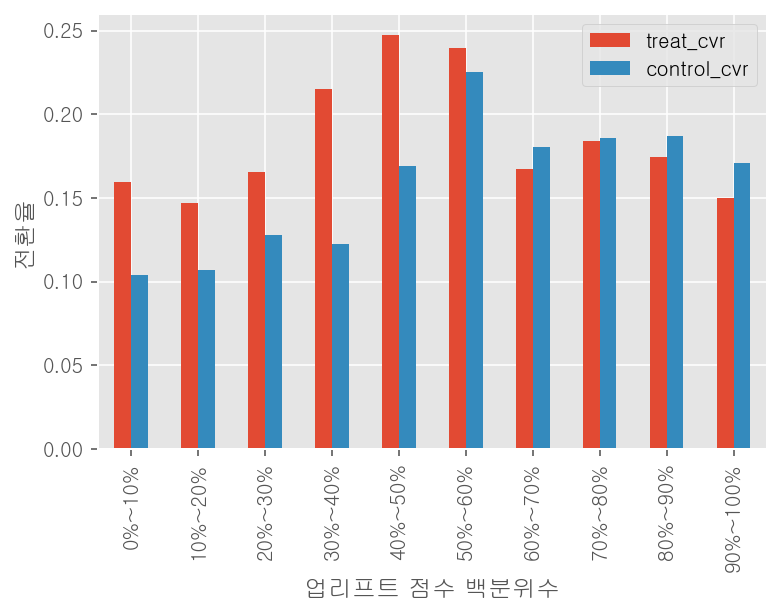

In [25]:
import matplotlib.pyplot as plt

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))
quantile_data = []

for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]
    
    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)
    
    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)
    
    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    
    quantile_data.append([treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr])
        
    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel("업리프트 점수 백분위수")
plt.ylabel("전환율")

In [29]:
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]

df.head()

,is_cv,is_treat,score,treat_uu,control_uu,treat_cv,control_cv,treat_cvr,control_cvr,lift
0,False,False,0.84113,10583,10764,1961,1698,0.185297,0.157748,291.552397


Text(0, 0.5, '전환 건수')

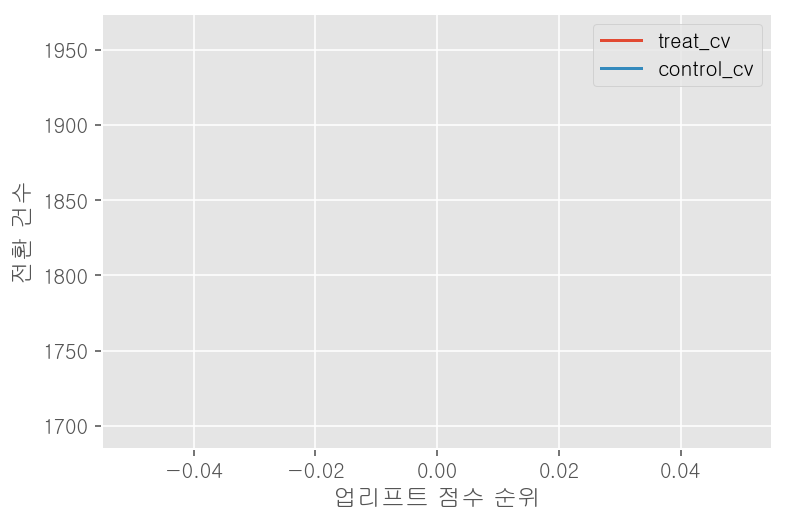

In [30]:
# 베이스라인 정보 추가
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환 건수")

Text(0, 0.5, '전환율')

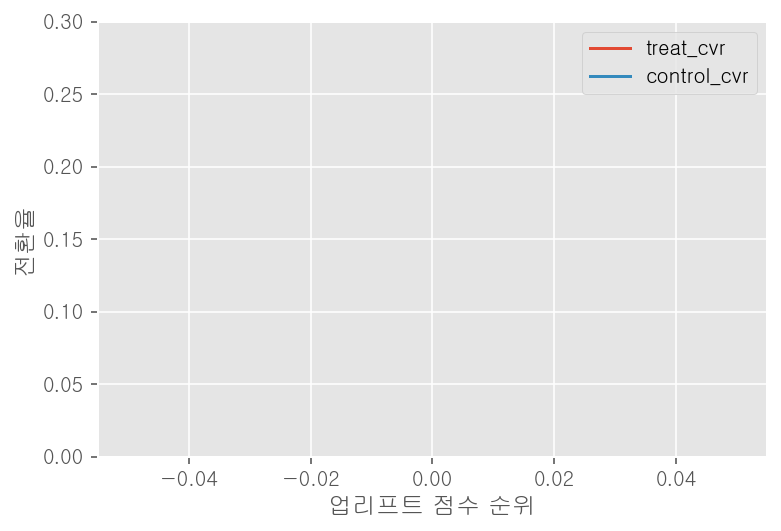

In [31]:
df.plot(y=["treat_cvr", "control_cvr"], ylim=[0, 0.3])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환율")

Text(0, 0.5, '전환 리프트')

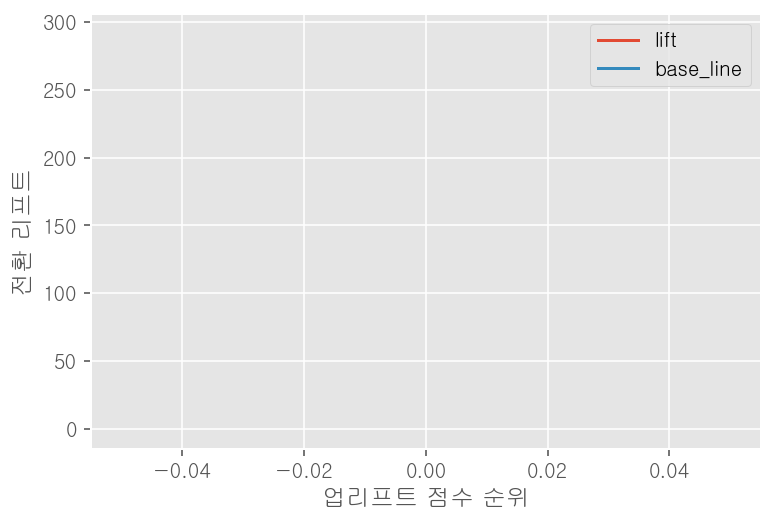

In [32]:
df.plot(y=["lift", "base_line"])
plt.xlabel("업리프트 점수 순위")
plt.ylabel("전환 리프트")

<AxesSubplot:title={'center':'리프트'}, xlabel='score'>

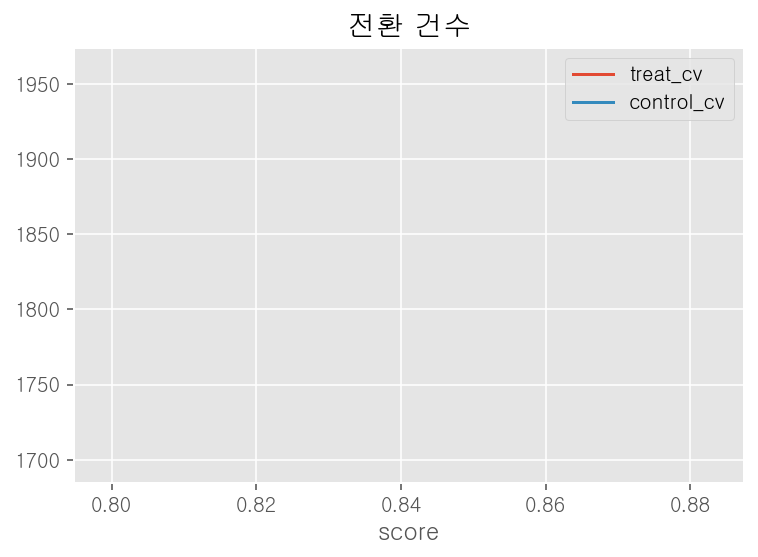

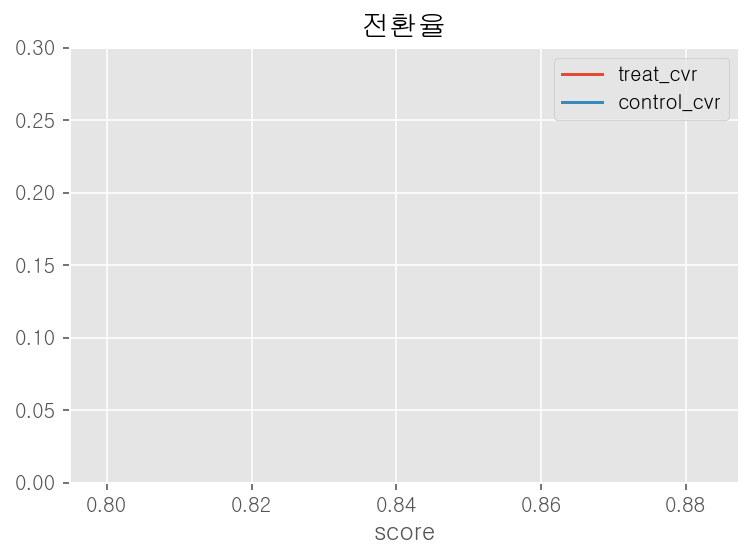

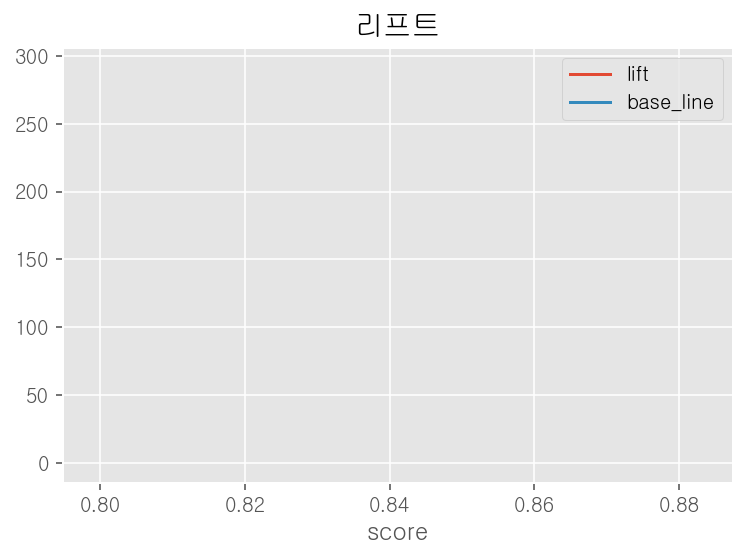

In [33]:
df.plot(y=["treat_cv", "control_cv"], x="score", title="전환 건수")
df.plot(y=["treat_cvr", "control_cvr"], ylim=[0, 0.3], x="score", title="전환율")
df.plot(y=["lift", "base_line"], x="score", title="리프트")